In [10]:
from datascience import *
from datascience.predicates import are
import numpy as np
from scipy import stats
from scipy import misc

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [44]:
def empirical_distribution(table, label, statistic, sample_size, repetitions):
    stats = simulate_statistic(table, label, statistic, sample_size, repetitions)
    Table().with_column('statistic', stats).hist()
    plots.xlabel('value of '+ statistic.__name__)
    plots.title('Empirical Distribution ('+str(repetitions)+' samples)')

In [12]:
def proportion(table, label, are_condition):
    return table.where(label, are_condition).num_rows/table.num_rows

## The Power of Random Samples

In [13]:
# (Almost) All United Airlines domestic flights out of SFO, June-August 2015

united = Table.read_table('united.csv')

In [14]:
# Delay is measured in minutes.
# If the delay is negative, the flight left early.
# We see 10 of the flights, and there are 13,722 more.

united

Date,Flight Number,Destination,Delay
6/1/15,73,HNL,257
6/1/15,217,EWR,28
6/1/15,237,STL,-3
6/1/15,250,SAN,0
6/1/15,267,PHL,64
6/1/15,273,SEA,-6
6/1/15,278,SEA,-8
6/1/15,292,EWR,12
6/1/15,300,HNL,20
6/1/15,317,IND,-10


In [15]:
# On this day last year ...

united.where('Date', '6/6/15').show()

Date,Flight Number,Destination,Delay
6/6/15,72,SEA,-5
6/6/15,73,HNL,39
6/6/15,267,MCO,-1
6/6/15,273,SEA,2
6/6/15,300,HNL,63
6/6/15,302,DEN,5
6/6/15,311,PHX,1
6/6/15,317,IND,-1
6/6/15,322,SEA,-1
6/6/15,325,BOS,35


In [16]:
# For ease of visualization, we will group the times into tens

every_ten = np.arange(-10, 301, 10)
every_ten

array([-10,   0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110,
       120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240,
       250, 260, 270, 280, 290, 300])

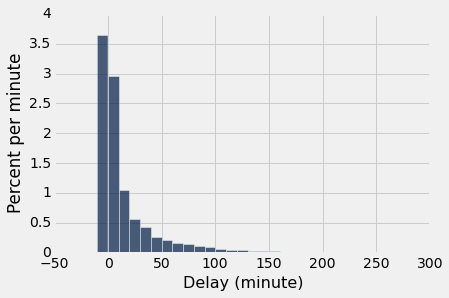

In [17]:
# Draw a "histogram" of all the delays, grouped by tens

united.select('Delay').hist(bins=every_ten, unit='minute')

In [18]:
# How to read the histogram: 
# Just under 3% per minute in the "0 to 10 minutes" bar, 
# so just less than 30% in that bar.

proportion(united, 'Delay', are.between(0, 10))

0.2955869501893388

In [19]:
# The number of flights in the dataset, as we saw earlier

united.num_rows

13732

### A helpful image

There is a box with 13,732 index cards, one card for each flight. On the card you have written the flight's delay. Imagining shuffling all the cards and pulling out 100 of them.

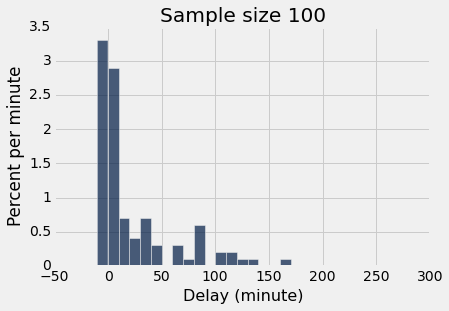

In [20]:
# Empirical distribution of a random sample of 100 delays;
# it looks a bit like the distribution of all the delays

united.sample(100).select('Delay').hist(bins=every_ten, unit='minute')
plots.title('Sample size 100')

### Empirical distributions

The histogram is the *empirical* or *observed* distribution of the sample. Empirical distributions are based on observed data.

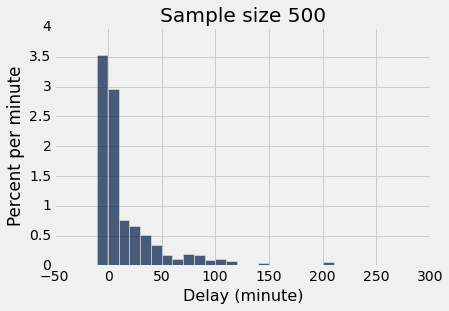

In [21]:
# Empirical distribution of a larger random sample;
# this one looks even more like the histogram of all the delays

united.sample(500).select('Delay').hist(bins=every_ten, unit='minute')
plots.title('Sample size 500')

### A version of "the law of averages"

- The empirical distribution of a large random sample is likely to resemble the distribution of the population. 

**Main use**

Typically, you just have a random sample; you don't know the distribution of the population. But based on what we've just observed, it's a pretty good bet that the distribution of the population resembles the distribution of your large random sample.

In [43]:
baby = Table.read_table('baby.csv')

In [44]:
# A random sample of 1,174 mothers and newborns in a hospital system
# Birth weights are in ounces; pregnancy weights in pounds

baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


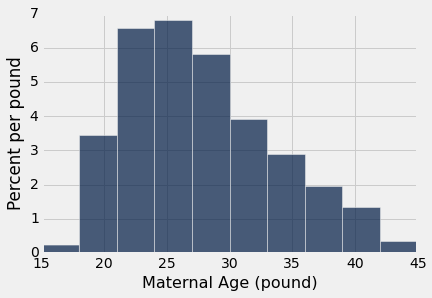

In [45]:
baby.select('Maternal Age').hist(unit='pound')

### Our first inference based on a random sample

The sample is large, and it was drawn at random. So it is reasonable to conclude that the distribution of the ages of the mothers in the population looks like the distribution of the sample above.

But it's important to keep in mind that when you draw a random sample:
- Most probably, the sample won't look exactly like the population. You expect some chance variation.
- There's a small probability that the sample will look quite different from the population.

So our inference could be off. The advantage of having drawn the sample at random is that probability theory or computational methods can help us quantify the likelihood and amount of error.

### Estimating a single parameter

- A *parameter* is any number that can be computed using the values in the population.

For example, the median delay of all the flights is a parameter.

In [46]:
np.median(united.column('Delay'))

2.0

- A *statistic* is any number that can be computed using the values in a random sample. Its value depends on which individuals are drawn in the sample.

The median of a sample is a statistic. If the sample is large, the sample is likely to resemble the population, so this statistic seems to be a reasonable estimate for the parameter which is the median of the population.

In [24]:
np.median(united.sample(125).column('Delay'))

1.0

In [27]:
# This function simulates one random sample of size sample_size
# and computes its median.

def random_sample_median(table, label, sample_size):
    return np.median(table.sample(sample_size).column(label))

In [55]:
random_sample_median(united, 'Delay', 125)

4.0

Each simulation produces a value of the statistic. 

In [26]:
# This function performs repeated simulations 
# and returns all the resulting values of the statistic.

def simulate_statistic(table, label, statistic, sample_size, repetitions):
    return np.array([statistic(table, label, sample_size) for i in range(repetitions)])

In [29]:
# Six replications of the statistic

simulate_statistic(united, 'Delay', random_sample_median, 125, 6)

array([ 2.,  1.,  4.,  4.,  0.,  2.])

### The sampling distribution of a statistic

The distribution of all the possible values of the statistic, across all the possible simulated samples, is called the *probability distribution* of the statistic. It is also called the *sampling distribution* of the statistic.

The sampling distribution shows us how close the statistic is likely to be to the parameter. Thus, as we will see in later sections, the sampling distribution helps us use the statistic to make inferences about the parameter.

So it is important to be able to calculate or at least approximate the sampling distribution. 

### A physical model for the sampling distribution

The sampling distribution consists of all the possible values of the statistic along with the exact proportion of times each value would occur if you simulated every possible random sample.

You can think of this as the distribution of an imaginary population. There is one index card for each possible simulated random sample. On the ticket you have written the value of the statistic for that sample.

### Approximating the sampling distribution

There are many, many different random samples. But probability theory is powerful, and for many statistics there are mathematical formulas that specify the sampling distribution exactly or provide good approximations.

But for many statistics, calculating a formula for the sampling distribution exactly or even approximately is intractable without the use of a computer.

In some situations, we can use the computer to simply list all of the possible random samples and compute the statistic based on each sample. Thus we can get the sampling distribution numerically.

But sometimes the population and sample sizes are so large that far too many random samples for even a computer to be able to list all of them. For such statistics, we don't know the value of the statistic on each index card. But we do know that to get a pretty good idea of the distribution of the values on all the cards, it's enough to take a large random sample of the index cards and just look at the empirical distribution of the values on those cards.

(0, 0.5)

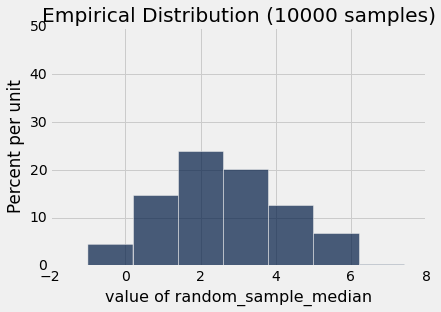

In [42]:
# Empirical distribution based on 10,000 repetitions

empirical_distribution(united, 'Delay', random_sample_median, 125, 10000)
plots.xlim(-2, 8)
plots.ylim(0, 0.5)

With high probability, the empirical distribution of a statistic based on numerous repetitions of the sampling procedure looks like the probability distribution of the statistic.

Therefore, we can conclude that the probabilities for the median of a random sample of size 125 look like the distribution above, though not exactly. 

Remember that we happen to know the value of the parameter in this case: the median delay among all the flights is 2 minutes. The distribution above shows that in a random sample of 125 delays, the median is quite likely to be somewhere in the interval 0 to 5. But there is also some chance, albeit a rather small one, that the sample median is outside that range. 

(0, 0.5)

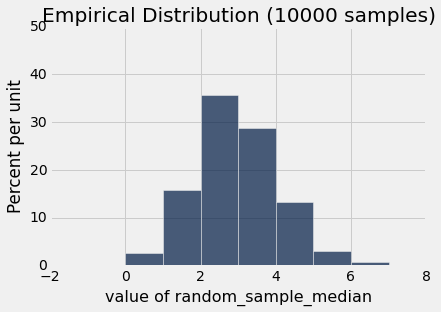

In [43]:
# Increasing the sample size

empirical_distribution(united, 'Delay', random_sample_median, 200, 10000)
plots.xlim(-2, 8)
plots.ylim(0, 0.5)

You can see that increasing the sample size has concentrated the probabilities over the 1-4 range.